# Laboratorium 3: Augmentacje danych i balans klas (DermaMNIST)


**Cele:**
- porównać wpływ różnych **augmentacji** (geometria, intensywność, heavy) na wyniki,
- zastosować metody **balansu klas**: wagi w `CrossEntropy`, `WeightedRandomSampler`,
- przeprowadzić rzetelną **ewaluację** (Loss, Accuracy, Macro-Precision/Recall/F1, Confusion Matrix),
- zebrać wyniki w tabeli i wyciągnąć wnioski.

> **Dataset:** **DermaMNIST (MedMNIST)** – 7-klasowa klasyfikacja zmian skórnych, automatyczny download.

> Uwaga: architektura CNN będzie prosta (dla 28×28×3); skupiamy się na augmentacjach i balansie klas.

Augmentacja danych (ang. data augmentation) to zestaw technik sztucznego powiększania i urozmaicania zbioru treningowego poprzez modyfikacje istniejących danych. Istniejące próbki przekształca się tak, aby powstały ich różnorodne warianty, ale zachowujące tę samą etykietę (klasę). Przykłady dla obrazów:
- obrót, odbicie lustrzane, przycięcie, skalowanie, przesunięcie,
- zmiana jasności, kontrastu, koloru, dodanie szumu,
- losowe maskowanie fragmentów obrazu (Cutout, Random Erasing).

Stosowana jest ona w celu: zwiększenia rozmiaru zbioru treningowego – szczególnie ważne, gdy mamy mało przykładów, poprawy generalizacji – model uczy się odporniejszych cech (mniejszy overfitting), symulacji warunków rzeczywistych – różne oświetlenia, kąty patrzenia czy szumy w danych, wyrównania zbioru – generowanie dodatkowych przykładów dla klas, których jest mniej.

## 0) Instalacja i importy

In [40]:
# !pip -q install medmnist torchmetrics tqdm scikit-learn pandas

import os, random, math, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm.auto import tqdm

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)

import medmnist
from medmnist import DermaMNIST, INFO

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


## 1) Pobranie danych (DermaMNIST, MedMNIST) + szybki podgląd i rozkład klas

Skrypt automatycznie pobiera zbiór **DermaMNIST**. Poniższy kod sprawdza rozmiar danych i etykiety.
Wyświetlone zostaje również 6 pierwszych próbek z tego zbioru.

Zwróć uwagę na rozkład klas w wykorzystywanym zbiorze. Co można o nim powiedzieć?

Opis: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
Liczba klas: 7 ; label map: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
Rozmiary: 7007 1003 2005


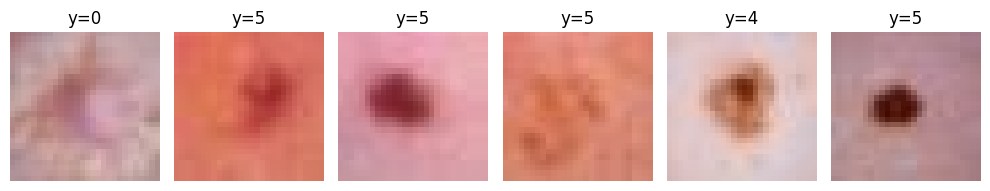

Rozkład klas (train): {0: 228, 1: 359, 2: 769, 3: 80, 4: 779, 5: 4693, 6: 99}


In [41]:
DATA_ROOT = './data/dermamnist'
os.makedirs(DATA_ROOT, exist_ok=True)
info = INFO['dermamnist']
NUM_CLASSES = len(info['label'])
print('Opis:', info['description'])
print('Liczba klas:', NUM_CLASSES, '; label map:', info['label'])

# as_rgb=True -> 3 kanały
train_raw = DermaMNIST(split='train', download=True, root=DATA_ROOT, as_rgb=True)
val_raw   = DermaMNIST(split='val',   download=True, root=DATA_ROOT, as_rgb=True)
test_raw  = DermaMNIST(split='test',  download=True, root=DATA_ROOT, as_rgb=True)
print('Rozmiary:', len(train_raw), len(val_raw), len(test_raw))

# podgląd kilku przykładów
fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    img, y = train_raw[i]
    axes[i].imshow(np.array(img))
    axes[i].set_title(f'y={int(y.squeeze().item())}')
    axes[i].axis('off')
plt.tight_layout(); plt.show()

# Rozkład klas w train
vals, cnts = np.unique(train_raw.labels.squeeze(), return_counts=True)
print('Rozkład klas (train):', dict(zip(vals.tolist(), cnts.tolist())))

## Zadanie 1 – Dataset z przełączanymi augmentacjami i normalizacją

W następnym fragmencie kodu chcemy przygotować różn warianty augmentacji danych, które będą wykorzystane do uczenia sieci i porównania wyników. W tym celu korzystamy z klasy `transforms` z biblioteki `torchvision`.

1. Przygotuj najprostszą, bazową transformację danych. Zawiera ona przekształcenia, które będą obecne we wszystkich innych wariantach augmentacji.
2. Do stworzenia pojedynczego wariantu wykorzystujemy funkcję `transforms.Compose`. Przyjmuje ona listę transformacji, które powinny być wykonane na wczytywanych danych.
3. Podstawowy wariant powinien zawierać dwie transformacje: `transforms.ToTensor()` i `transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])`. Pierwsza z nich przekształca dane do typu tensora z PyTorch z odpowiednią kolejnością wymiarów. Dodatkowo dla obrazów typu `uint8` zmienia ich zakres do `[0.0, 1.0]`. Jeśli wejściem są wartości typu `float`, to zostaną one zachowane. Druga z kolei zmienia zakres danych do przedziału `[-1.0, 1.0]` (zakłądając, że wejście ma zakres `[0.0, 1.0]`). Jej arguemntami są paramtry normalizacji dla poszczególnych kanałów.
4. Stwórz transformację, która przed bazowymi wykona dodatkowo odbicie w poziomie `transforms.RandomHorizontalFlip` i rotację obrazu `transforms.RandomRotation`. Argumentem pierwszej jest prawdopodobieństwo odbicia, a drugiej maksymalny kąt rotacji w stopniach.
5. Stwórz transformację, która przed bazowymi wykona dodatkowo losową zmianę kolorów `transforms.ColorJitter`. Argumentami są maksymalne zmiany dla danej właściwości, np. `transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02)`.
6. Czwarta transformacja powinna łączyć wszystkie wymienione wcześniej.
7. Napisz również funkcję `make_datasets`, która będzie tworzyć DataSet i aplikować transformacje przekazane jako argument do danych treningowych. Zwracać powinna 3 zbiory danych: treningowy, walidacyjny i testowy. Dla danych walidacyjnych i testowych stosujemy tylko podstawowy wariant transformacji. Transformacja jest przekazywana jako dodatkowy arguement podczas inicjalizacji obiektu klasy `DermaMNIST`.
8. Zdefiniuj `BATCH_SIZE`, `NUM_WORKERS` i `PIN_MEMORY`.

In [42]:
# Zadanie 1
transform_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_3 = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_4 = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

from PIL import Image

class DermaMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long).view(-1)
        return img, label

def create_dataset(dataset, transforms_list: list):
    return [DermaMNISTDataset(dataset, tf) for tf in transforms_list]



## Zadanie 2 – Prosta sieć CNN 3-kanałowa + pętle trening/ewaluacja

Zdefniujmy bardzo podobną sieć do wykorzystanej w poprzednim tygodniu. Poniżej znajduje się lista modyfikacji koniecznych do wykonania.

1. Liczba kanałów wejściowych: 3.
2. Liczba kanałów wyjściowych pierwszej warstwy konwolucyjnej: 16.
3. Liczba kanałów wyjściowych drugiej warstwy konwolucyjnej: 32.
4. Rozmiar obu konwolucji wynosi 3, a padding 1.
5. Wyjście pierwszej warstwy w pełni połączonej ma rozmiar 128.
6. Liczba klas (a więc i rozmiar wyjścia sieci) powinna być podawana jako argument.
7. Dodajmy również warstwę dropout o prawdopodobieństwie równym 0.25 `nn.Dropout(p=0.25)` pomiędzy warstwami w pełni połączonymi. Warstwa ta losowo wyłącza część neuronów z zadanym prawdopodobieństwem. Warstwa taka może poprawić generalizację sieci i sprawić, że będzie się uczyć bardziej ogólnych cech.
8. Zaimplementuj funkcję, która będzie wykonywać jedną epokę treningu (podobnie jak w poprzednim ćwiczeniu). Jej argumentami są trenowana sieć, DataLoader, optimalizator i obiekt funkcji straty. Nie musi ona liczyć dokładności, bo zaimplementujemy osobną funkcję do ewaluacji.
9. Zaimplementuj funkcję wykonującą ewaluację sieci. Jak argumenty przyjmuje ona instancję sieci i DataLoader. Zapamiętaj w dwóch listach predykcje sieci i etykiety. Po przetworzeniu danych połącz je w jeden wektor za pomocą funkcji `np.concatenate` i oblicz metryki klasyfikacji takie jak: dokładność (accuracy), precyzja (precision), czułość (recall) i F1-score. W tym calu wykozystaj funkcje `accuracy_score`, `precision_score`, `recall_score` i `f1_score`.
    - Dokładność jest odsetkiem poprawnie sklasyfikowanych próbek.
    - Precyzja mówi ile z przewidzianych klasyfikacji danej klasy naprawdę należało do danej klasy. Dodajemy argument `average='macro`, który sprawia, że finalny wynik jest uśrednioną wartością dla wszystkich klas.
    - Czułość mówi ile z prawdziwych przykładów danej klasy zostało poprawnie znalezionych przez model. W tym przypadku również chcemy uśrednić wyniki dla wszystkich klas.
    - F1-score jest średnią harmoniczną z precyzji i czułości. Również chcemy go uśrednić dla wszystkich klas.
Na wyjście sieci przekaż słownik zawierający obliczone metryki, wektor predykcji sieci oraz wektor rzeczywistych etykiet.

Dlaczego w przypadku wykorzystywanego zbioru po prostu sprawdzanie dokładności może nie być dobrą metodą oceny jej skuteczności?

In [43]:
# Zadanie 2
from torchvision.models import resnet18, ResNet18_Weights
import pandas as pd
from tqdm.auto import tqdm

model = resnet18(weights=ResNet18_Weights)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
optim = torch.optim.Adam(params=model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

def run_epoch(model, dataloader, device, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    lossTotal = 0.0
    correctTotal = 0
    total = 0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device).long().view(-1)

        if is_train:
            optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)

        if is_train:
            loss.backward()
            optimizer.step()

        lossTotal += loss.item() * x.size(0)
        preds = outputs.argmax(dim=1)
        correctTotal += (preds == y).sum().item()
        total += y.size(0)

    return lossTotal / total, correctTotal / total

def eval_model(model, loader, device):
    model.eval()
    preds_list = []
    labels_list = []

    with torch.inference_mode():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            pred = outputs.argmax(dim=1)
            preds_list.extend(pred.cpu().tolist())
            labels_list.extend(labels.cpu().tolist())

    acc = accuracy_score(labels_list, preds_list)
    prec = precision_score(labels_list, preds_list, average='macro')
    recall = recall_score(labels_list, preds_list, average='macro')
    f1 = f1_score(labels_list, preds_list, average='macro')

    return pd.DataFrame({"acc": [acc], "prec": [prec], "recall": [recall], "f1": [f1]})   

## Zadanie 3 – Przeprowadzenie treningu i sprawdzenie augmentacji

Przeprowadź trening zdefiniowanej sieci dla każdego z wariantów augmentacji danych treningowych. Dla wielu przypadków testowych dobrze jest stworzyć strukturę zawierającą scenariusze testowe i uruchomić je w pętli.

1. Dla każdego pzypadku stwórz 3 DataSety z odpowiednimi transformacjami (użyj przygotowanej wcześniej funkcji), a następnie dla każdego z nich DataLoader.
2. Dla każdego przypadku stwórz instancję trenowanej sieci, optymalizator `torch.optim.Adam` i funkcję straty `nn.CrossEntropyLoss`.
3. Stwórz puste listy do śledzenia postępu treningu: `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies`, `val_f1_scores`, `epochs_list`.
4. Dodatkowo chcemy zapamiętać model, który dla danego treningu osiągnął najlepszą wartość metryki F1-macro. Wymaga to zapamiętania najlepszej do tej pory widzianej metryki i poprawnej inicjalizacji.
5. Napisz pętlę trenującą. W każdej iteracji chcemy:
    - wykonać epokę treningu,
    - obliczyć i zapamiętać metryki dla zbioru treningowego,
    - obliczyć i zapamiętać metryki dla zbioru walidacyjnego,
    - obliczyć i zapamiętać stratę dla zbioru treningowego,
    - obliczyć i zapamiętać stratę dla zbioru walidacyjnego,
    - sprawdzić czy jest to najlepszy do tej pory model,
    - (opcjonalnie) wyświetlać wyniki po każdej epoce.
6. Po zakończonym treningu wyświetl 2 wykresy:
    - wykres staty dla zbioru treningowego i walidacyjnego,
    - wykres wyznaczonych metryk dla zbioru treningowego i walidayjnego.
7. Wykonaj ewaluację dla zbioru testowego. Wyświetl macierz pomyłek (podobnie jak w poprzednim ćwiczeniu).

Dobrze jest zapamiętywać wyniki metryki zbioru testowego dla wszystkich testowanych przypadków i wyświetlić je na końcu w formie tabeli.

In [45]:
# Zadanie 3
transform_list = [transform_1, transform_2, transform_3, transform_4]

NUM_CLASSES = len(np.unique(train_raw.labels))
NUM_EPOCHS = 10

results = []

for i, tf in enumerate(transform_list):
    print(f"\n--- Trening dla transformacji {i+1} ---")
    
    dataset = DermaMNISTDataset(train_raw, tf)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    model = resnet18(weights=ResNet18_Weights)
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)  
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(NUM_EPOCHS)):
        loss, acc_train = run_epoch(model, loader, device, criterion, optimizer)
        print(f"Loss: {loss:.4f}, Accuracy (train): {acc_train:.4f}")
        
        eval_loader = DataLoader(dataset, batch_size=32)
        df_metrics = eval_model(model, eval_loader, device)
        df_metrics["transform"] = f"transform_{i+1}"
    
    results.append(df_metrics)

final_results = pd.concat(results, ignore_index=True)
print(final_results)


--- Trening dla transformacji 1 ---


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|                                                                                                                                                           | 0/10 [00:00<?, ?it/s]

Loss: 0.9441, Accuracy (train): 0.6689


 10%|██████████████▋                                                                                                                                    | 1/10 [00:10<01:35, 10.65s/it]

Loss: 0.6707, Accuracy (train): 0.7551


 20%|█████████████████████████████▍                                                                                                                     | 2/10 [00:21<01:24, 10.61s/it]

Loss: 0.5587, Accuracy (train): 0.7943


 30%|████████████████████████████████████████████                                                                                                       | 3/10 [00:31<01:14, 10.64s/it]

Loss: 0.4904, Accuracy (train): 0.8222


 40%|██████████████████████████████████████████████████████████▊                                                                                        | 4/10 [00:42<01:04, 10.72s/it]

Loss: 0.3988, Accuracy (train): 0.8570


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 5/10 [00:53<00:53, 10.73s/it]

Loss: 0.3342, Accuracy (train): 0.8790


 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6/10 [01:04<00:42, 10.72s/it]

Loss: 0.2894, Accuracy (train): 0.8951


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7/10 [01:14<00:32, 10.70s/it]

Loss: 0.2448, Accuracy (train): 0.9145


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8/10 [01:25<00:21, 10.72s/it]

Loss: 0.2035, Accuracy (train): 0.9271


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9/10 [01:36<00:10, 10.72s/it]

Loss: 0.1735, Accuracy (train): 0.9378


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.71s/it]
/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Trening dla transformacji 2 ---


  0%|                                                                                                                                                           | 0/10 [00:00<?, ?it/s]

Loss: 0.9630, Accuracy (train): 0.6685


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 10%|██████████████▋                                                                                                                                    | 1/10 [00:12<01:54, 12.74s/it]

Loss: 0.7916, Accuracy (train): 0.7136


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 20%|█████████████████████████████▍                                                                                                                     | 2/10 [00:25<01:42, 12.75s/it]

Loss: 0.7501, Accuracy (train): 0.7250


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 30%|████████████████████████████████████████████                                                                                                       | 3/10 [00:38<01:29, 12.82s/it]

Loss: 0.7102, Accuracy (train): 0.7361


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 40%|██████████████████████████████████████████████████████████▊                                                                                        | 4/10 [00:51<01:16, 12.77s/it]

Loss: 0.7008, Accuracy (train): 0.7435


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 5/10 [01:03<01:03, 12.77s/it]

Loss: 0.6887, Accuracy (train): 0.7460


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6/10 [01:16<00:50, 12.72s/it]

Loss: 0.6547, Accuracy (train): 0.7565


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7/10 [01:29<00:38, 12.75s/it]

Loss: 0.6478, Accuracy (train): 0.7584


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8/10 [01:42<00:25, 12.78s/it]

Loss: 0.6540, Accuracy (train): 0.7578


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9/10 [01:55<00:12, 12.82s/it]

Loss: 0.6275, Accuracy (train): 0.7689


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.80s/it]
/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Trening dla transformacji 3 ---


  0%|                                                                                                                                                           | 0/10 [00:00<?, ?it/s]

Loss: 0.9283, Accuracy (train): 0.6748


  0%|                                                                                                                                                           | 0/10 [00:12<?, ?it/s]


KeyboardInterrupt: 

## Zadanie 4 – Balans klas: wagi, WeightedRandomSampler

Wykorzystamy dodatkowo dwie metody radzenia sobie ze zbiorami danych i niezbalansowanych klasach.
Pierwszą są wagi klas (class weights). Działa to w ten sposób, że jeśli jakaś klasa jest rzadka, to jej błędy mają być bardziej kosztowne. Dodając większe wagi dla rzadkich klas w funkcji straty, uczymy model, żeby przykładał do nich większą wagę.

Drugą metodą jest zmiana doboru próbek (WeightedRandomSampler). W tym przypadku rzadkie klasy są częściej losowane do batcha, a więc model widzi ich proporcjonalnie więcej. Również w tym przypadku tworzymy wagi dla każdej klasy.

1. Zaimplementuj funkcję, która będzie obliczać wagi dla klas. Jej argumentem jest lista rzeczywistych etykiet zbioru treningowego (metoda `.labels` dla zbioru treningowego).
2. Wewnątrz funkcji sprawdzamy ile jest wystąpień dla każdej etykiety (funkcja `np.unique`). Jej pierwszym argumentem są etykiety. Przekazujemy jej również argument `return_counts=True`, który powoduje, że funkcja zwraca również liczbę wystąpień.
3. Następnie dzielimy otrzymane wystąpienia przez liczbę próbek. W ten sposób obliczamy częstość występowania danej klasy.
4. Chcemy, aby waga była odwrotnie proporcjonalna do częstości jej występowania, a więc obliczamy odwrotność poprzedniej wartości. Warto dodać zabezpieczenie przed zbyt małą wartością mianownika `np.maximum(freq, 1e-8)`.
5. Normalizujemy wartości obliczonych wag tak, żeby ich suma wynosiła liczbę możliwych etykiet.
6. Zwracamy tensor wag `torch.tensor` z danymi typu `torch.float32`.
7. Wyświetl obliczone wagi.
8. Na podstawie wag zwróconych przez zaimplementowaną funkcję stworzymy sampler do danych treningowych. W tym celu należy obliczyć wagę dla każdej próbki ze zbioru treningowego. Bierzemy więc listę etykiet próbek i sprawdzamy jakie prawdopodobieństwo odpowiada każdej z nich (a więc robimy Look-Up Table).
9. Obliczone nagi dla każdej próbki przezkazujemy do klasy `WeightedRandomSampler` jako argument `weights`. Oprócz tego konieczne jst przekazanie argumentu `num_samples`, czyli liczba próbek, i podanie argumentu `replacement` jako `True`.

In [ ]:
# Zadanie 4

## Zadanie 5 – Przeprowadzenie treningu i sprawdzenie wpływu testowanych metod na wynik

Przeprowadzamy trening podobno do zadania 3, ale tym razem zamiast metod augumentacji sprawdzamy wpływ wag strat i częstości doboru próbek.

1. Aby sprawdzić wpływ wag, do funkcji straty należy przekazać ich wektor `nn.CrossEntropyLoss(weight=weights_ce.to(device))`.
2. Aby sprawdzić wpływ samplera, należy go przekazać do DataLoadera jako argument `sampler`.
3. Sprawdź wpływ zaimplementowanych metod na wyniki treningu przeprowadzając eksperymenty w podobny sposób jak w zadaniu 3.

In [ ]:
# Zadanie 5

## Zadanie 6 – Eksperymenty własne

Spróbuj połączyć poznane metody tak, aby uzysać jak największy wskaźnik F1-macro. Możesz dodatkowo użyć innych metod augmentacji danych, takich jak: `transforms.RandomVerticalFlip`, `transforms.RandomAffine`, `transforms.RandomResizedCrop`, `transforms.GaussianBlur`, `transforms.RandomApply`, `transforms.RandomAdjustSharpness`, `transforms.RandomGrayscale`, `transforms.RandomErasing`, `transforms.Lambda` (może zostać użyte do uzyskania szumu Gaussowskiego: `transforms.Lambda(lambda x: torch.clamp(x + 0.03*torch.randn_like(x), -1, 1))`, w tej formie używana już po normalizacji zakresu), `transforms.TrivialAugmentWide`, `transforms.RandAugment`.

Pochwal się uzyskanym wynikiem.

In [ ]:
# Zadanie 6

## Podsumowanie – Wnioski

- Która strategia **augmentacji** dała najwyższą Macro-F1?
- Czy **wagi** w CE lub **sampler** poprawiły Recall klas rzadkich?
- Jakie klasy najczęściej się mylą (macierz pomyłek)?